In [1]:
from astropy.io import fits
import pandas as pd
from astropy.table import Table
from astropy.table import vstack
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
Ncm.cfg_init()

In [8]:
hdul_short = fits.open("JPAS_mergedproc2a_short.fits")
hdul = fits.open("JPAS_mergedproc2a.fits")

table_short = hdul_short[1].data
table = hdul[1].data

halo_table_short = table_short[(table_short['upid'] == -1) &  (table_short['Mvir'] >= 10**12) & (table_short['Mvir'] <= 10**15)]
halo_table = table[(table['upid'] == -1) &  (table['Mvir'] >= 10**12) & (table['Mvir'] <= 10**15)]

halo_table_short = table_short[(table_short['upid'] == -1)]
halo_table = table[(table['upid'] == -1)]

print(halo_table_short.columns)

print(halo_table.size)
print(halo_table_short.size)

print(np.log10(halo_table['Mvir'].min()))
print(np.log10(halo_table_short['Mvir'].min()))

print(np.log10(halo_table['Mvir'].max()))
print(np.log10(halo_table_short['Mvir'].max()))



print(halo_table['redshift_R'].min())
print(halo_table['redshift_R'].max())

print(halo_table['RA'].min())
print(halo_table['RA'].max())
print(table['RA'].min())
print(table['RA'].max())

print(halo_table_short['ebv'].max())

ColDefs(
    name = 'Mvir'; format = 'D'
    name = 'desc_id'; format = 'K'
    name = 'icl'; format = 'D'
    name = 'id'; format = 'K'
    name = 'upid'; format = 'K'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'r_mag'; format = 'D'
    name = 'i_mag'; format = 'D'
    name = 'ebv'; format = 'D'
    name = 'red'; format = 'I'
    name = 'photoz_error_4tray'; format = 'D'
    name = 'photoz_4trays'; format = 'D'
)
3245769
40987663
9.856970427445594
9.856970427445594
15.442636508542105
15.442636508542105
0.0011156798169948635
0.394639067404309
110.0
230.0
nan
nan
0.28958746790885925


In [3]:
area = 4109.3
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegac", 0.2603)
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0)


prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.02745)
prim.param_set_by_name("n_SA", 0.9667)



reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)


dist = Nc.Distance.new(2.0)

tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
print("sigma8 = " + str(cosmo.sigma8(psf)))


A_s = np.exp(prim.param_get_by_name("ln10e10ASA")) * 1.0e-10
fact = (0.8159 / psml.sigma_tophat_R(cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h())) ** 2
prim.param_set_by_name("ln10e10ASA", np.log(1.0e10 * A_s * fact))

print("sigma8 = " + str(cosmo.sigma8(psf)))


mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area(area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, None)
cad.set_area(area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)

#σ_8 = 0.8159

#mass proxy
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * (12 ), lnM_max=np.log(10.0) * (15.0))

#photo-z
cluster_z = Nc.ClusterRedshiftNodist (z_min = 0.0, z_max = 0.394637021162255)

sigma8 = 0.8223626056629462
sigma8 = 0.8158999996211252


In [ ]:
multiplicity = [Nc.MultiplicityFuncTinker.new() , Nc.MultiplicityFuncDespali.new() , Nc.MultiplicityFuncDespali.new()] 
legend = ['Tinker','Despali' , 'Despali Virial']

for mult in range(len(multiplicity)):

    mass = np.linspace(np.log(10) * (12), np.log(10.0) * (15.3 ), 100)
    mass10 = np.linspace(12 , 15.3   , 100)
    mass_plot = []
    n_bin = []

    mulf = multiplicity[mult]
    mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
    mulf.set_Delta(200.0)
    if mult ==2:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.set_area(area * (np.pi / 180) ** 2)
    
    hmf.prepare(cosmo)
    cad = Nc.ClusterAbundance.new(hmf, None)
    hmf.prepare(cosmo)
    cad.prepare(cosmo , cluster_z , cluster_m)
    cad.set_area(area * (np.pi / 180) ** 2)
    print(cad.n(cosmo , cluster_z , cluster_m))
    for i in range(len(mass)-1):
        n_bin.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m , [mass[i]] ,[mass[i+1]],None ,[0.0020287445400499256] , [ 0.394637021162255] , None))
        mass_plot.append((mass10[i] + mass10[i+1])/2)
    
    
    
    
    
    plt.plot(mass_plot , n_bin , label = "%s" %(legend[mult]))
    
plt.xlim(np.log10(halo_table['Mvir'].min()/cosmo.h()) , np.log10(halo_table['Mvir'].max()/cosmo.h()))
plt.legend()
plt.xlabel(r"$log_{10}(M/M_{\bigodot})$")
plt.ylabel(r"n_M")
plt.yscale("log")
plt.hist(np.log10(halo_table['Mvir'])-np.log10(cosmo.h()), bins=(len(mass10-1)))
plt.savefig("halo_mass_function_log10M.jpg")
plt.show()

2826329.3281537634
2874444.6796671394
3621380.9734538677


2826329.3281537634
2874444.6796671394
3621380.9734538677


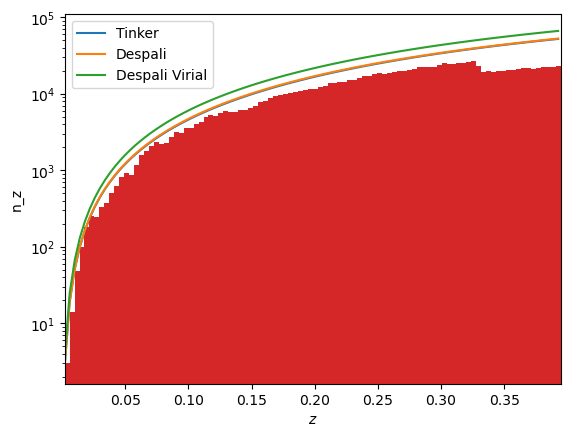

In [7]:
multiplicity = [Nc.MultiplicityFuncTinker.new() , Nc.MultiplicityFuncDespali.new() , Nc.MultiplicityFuncDespali.new()] 
legend = ['Tinker' , 'Despali' , 'Despali Virial']

for mult in range(len(multiplicity)):

    z = np.linspace(0.0, 0.394637021162255 , 100)
    z_plot = []
    n_bin = []
    
    mulf = multiplicity[mult]
    mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
    mulf.set_Delta(200.0)
    if mult ==2:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)

    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.set_area(area * (np.pi / 180) ** 2)
    
    hmf.prepare(cosmo)
    cad = Nc.ClusterAbundance.new(hmf, None)
    hmf.prepare(cosmo)
    cad.prepare(cosmo , cluster_z , cluster_m)
    cad.set_area(area * (np.pi / 180) ** 2)
    print(cad.n(cosmo , cluster_z , cluster_m))
    for i in range(len(z)-1):
        n_bin.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m , [np.log(10)*(12 - np.log10(cosmo.h()))] ,[np.log(10.0) * (15.0 - np.log10(cosmo.h()))],None ,[z[i]] , [z[i+1]] , None))
        z_plot.append((z[i] + z[i+1])/2)
    
    
    
    
    
    plt.plot(z_plot , n_bin , label = "%s" %(legend[mult]))
    
plt.xlim(halo_table['redshift_R'].min() , halo_table['redshift_R'].max())
plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"n_z")
plt.yscale("log")
plt.hist(halo_table['redshift_R'], bins=(len(mass10-1)))
plt.savefig("halo_mass_function_z.jpg")
plt.show()